In [0]:
# core
import numpy.matlib # you have to add it !
import numpy as np
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# Examen de Data Science



Examen de 3 heures, sur machine, tout documents autorisés. Pour l'anonymisation de votre rendu, veuillez suivre les consignes : 

- Choisissez un numéro aléatoire à 6 chiffres, le plus aléatoire possible..
- Ecrivez ce numéro sur une feuille, ainsi que votre nom et numéro d'étudiant. 
- Pliez cette feuille en 4, et donnez la à la fin de l'examen au moment d'émarger.
- Zippez votre fichier notebook, et nommez l'archive avec votre numéro aléatoire.
- Envoyez l'archive via la page : https://pageperso.lis-lab.fr/thierry.artieres/cgi-bin/upload/upload.php


<hr/>

## Partie 1 : Explication dans les modèles linéaires

L'interprétation des décisions d'un modèle appris par apprentissage automatique n'est pas immédiate et ces modèles sont souvent qualifiés de boites noires.

Une information souvent pertinente pour favoriser l'interprétabilité de la décision d'un modèle est de produire les variables d'entrée qui ont le plus influé sur cette décision.

Dans le cas de modèles linéaires les variables d'entrée qui infuent le plus sur une décision  sont celles correpsondant aux poids les plus forts, et cette information est facile à obtenir.   
Nous allons utiliser cette idée simple pour aider à l'interprétabilté de modèles non linéaires à l'image de la méthode proposée dans l'article https://arxiv.org/pdf/1602.04938v1.pdf publié dans la conférence ienternationale KDD 2016. 



### Question 1. Construction de données contenant artificiellement des variables inutiles 
Nous utilserons le jeu de données simple des iris, que la cellule suivante permet de récupérer.

- Modifez les données d'entrée pour rajouter 20 variables d'entrée (les données sont maintenant exprimées en dimension 24) qui sont du pur bruit gaussien de moyenne nulle et de variance 1. 

Raisonnablement un modèle apprenant à partir de ces données ne devrait faire aucun cas des 20 variables aléatoires non informatives sur la classe des exemples et n'exploiter que les 4 variables d'origine.

In [12]:
# Les exemples sont dans iris.data, sont en dimesion 4,
# et les classes de ces exemples sont dans iris.target

iris = datasets.load_iris()
#print(iris.keys())

# convenient
original_data = iris.data
original_target = iris.target
original_target_names = iris.target_names
original_feature_names = iris.feature_names

print(f'original data shape {original_data.shape}')
print(f'original target shape {original_target.shape}')
print(f'original target names {original_target_names}')
print(f'original feature names {original_feature_names}')

original iris shape (150, 4)
original target shape (150,)
original target names ['setosa' 'versicolor' 'virginica']
original feature names ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [33]:
# on concatène 20 features de bruit gaussien à variance 1
def generate_noise(n_samples, n_features, variance):
    return np.random.normal(0, variance, (n_samples, n_features))

n_noisy_features = 20
noise_data = generate_noise(original_data.shape[0], n_noisy_features, 1)
noise_feature_names = ['noise' for _ in range(n_noisy_features)]

data = np.concatenate((original_data, noise_data), axis=1)
feature_names = np.concatenate((original_feature_names, noise_names), axis=0)

print(f'new data shape {data.shape}')
print(f'new feature_names {feature_names}')

new data shape (150, 24)
new feature_names ['sepal length (cm)' 'sepal width (cm)' 'petal length (cm)'
 'petal width (cm)' 'noise' 'noise' 'noise' 'noise' 'noise' 'noise'
 'noise' 'noise' 'noise' 'noise' 'noise' 'noise' 'noise' 'noise' 'noise'
 'noise' 'noise' 'noise' 'noise' 'noise']


### Question 2. Identification de features importants avec un SVM linéaire
 
Apprenez un classifieur linéaire de type SVM sur les données ci-dessus et plottez l'importance de chacune des caractéristiques dans le modèle appris.

Pour mesurer l'importance d'une variable vous pourrez utiliser directement les paramètres du modèle (en général dans model.coef_) et utiliser la valeur au carré ou en valeur absolue.

Le SVM linéaire est il efficace à ne considérer que les features informatifs et à délaisser les features aléatoires que vous avez ajoutés ?

penalty=’l2’, loss=’squared_hinge’, dual=True, tol=0.0001, C=1.0, multi_class=’ovr’, fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000

In [52]:
clf = svm.LinearSVC()
clf.fit(data, original_target)
print(clf.coef_.shape)

# valeurs absolues des coefficients pour éviter qu'un poids à -1 d'un modèle
# `compense` un poids à 1 dans un autre modèle, ce qui reviendrait à dire que 
# la variable n'est pas explicative alors qu'elle l'est !
abs_coefficients = np.abs(clf.coef_)

# on fait la moyenne des 3 modèles appris par le SVM
coefficients = abs_coefficients.sum(axis=0) / abs_coefficients.shape[0]
print(coefficients)

(3, 24)
[0.38546574 0.92537482 0.93508425 1.19797481 0.08396517 0.07320467
 0.0695005  0.21158014 0.18021566 0.03458267 0.05756674 0.06991574
 0.03757137 0.09400878 0.19490766 0.05888296 0.04670502 0.0377274
 0.02512827 0.06410276 0.0664261  0.10933012 0.06138006 0.07086434]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
def plot_coefficients(coefficients, feature_names, top_features=24):
    # - pour ordre décroissant
    top_coefficients = np.argsort(-coefficients)
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coefficients[top_coefficients]]
    plt.bar(np.arange(top_features), coefficients[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, top_features),
               feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

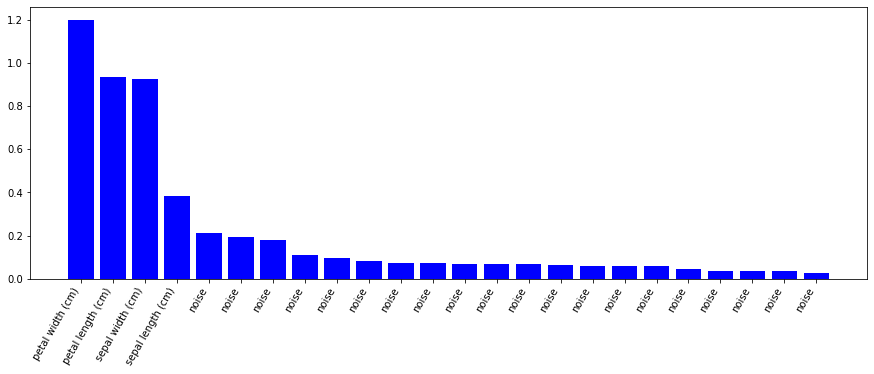

In [54]:
plot_coefficients(coefficients, feature_names, top_features=data.shape[1])

### Question 3. Explication dans des modèles non linéaires

Nous allons utiliser la stratégie précédente (identification de variables pertinentes avec un modèle linéaire) pour proposer une stratégie d'explication de décisions de modèles non linéaires. Nous utiliserons les données Digit de sklearn (voir plus  loin du code pour les récupérer)

L'idée que vous allez implémenter est la suivante. Dans un premier temps :

1/ On apprend un classifieur de type SVM non linéaire (avec noyau RBF) sur les données de façon classique, en divisant l'ensemble de données entre apprentissage et test. Nul besoin ici de chercher à atteindre une performance optimale (vous devriez facilement atteindre de 95% à 98% de précision en généralisation avec un SVM non linéaire). On note le classificuer appris $clf$. 

2/ On teste le classifieur obtenu sur les données de test et on choisit un exemple particulier de test, appellons le $x$ dans la suite, pour lequel on va essayer de comprendre la classification. Choisissez le comme vous voulez, prenez de préference un exemple sur lequel le classifieur ne se trompe pas.

Dans un second temps on effectue la démarche suivante:

3/ On générère de nombreux exemples (plusieurs centaines) autour de $x$ en perturbant $x$ avec un bruit gaussien additif, c'est à dire qu'on génère des exemples perturbés $x' = x  + \epsilon$ où les $\epsilon$ sont des vecteurs tirés aléaoirement avec un bruit gaussien de variance $\sigma$. On note $B$ la base des exemples $x'$ perturbés.

4/ On calcule la prédiction de $clf$ sur la base $B$, et on appelle ces prédictions $y_B$.

5/ On apprend un classifieur linéaire, noté $clf_{lin}$ dans la suite sur l'ensemble des exemples $B$ avec comme targets $y_B$. Ce classifieur est donc appris à reproduire le comportement du classifier $clf$ sur des exemples proches de l'exemple $x$.

6/ On identifie avec la méthode exposée plus haut les caracteristiques de l'entrée les plus importantes pour prédire la sortie du classifieur $clf_{lin}$. On dispose d'une mesure d'importance par pixel que l'on peut afficher sous la forme d'une image pour identifier les pixels les plus pertinents qui ont permis d'identifier l'exemple $x$. 

Ecrivez le code correspondant à ces traitements pour l'explication de la décision du classifieur appris sur un exemple particulier.

Note importante : Dans l'étape 3/ il est utile de régler le sigma de façon a ce que les classes prédites pour les exemples de l'ensemble $B$ soit à peu près équilibrées entre la vraie classe de l'exemple et d'autres classes. Réglez à la main le $\sigma$ pour obtenir cela.  

#### Base de chiffres digits
Nous allons utiliser la base de données Digits de sklearn. Les quelques cellules ci dessous sont extraites de la doc sklearn. 

In [97]:
# The digits dataset
digits = datasets.load_digits()
#print(digits.keys())

# convenient
original_data = digits.data
original_target = digits.target
original_target_names = digits.target_names
original_images = digits.images

print(f'original data shape {original_data.shape}')
print(f'original target shape {original_target.shape}')
print(f'original target names {original_target_names}')
print(f'original images shape {original_images.shape}')

original data shape (1797, 64)
original target shape (1797,)
original target names [0 1 2 3 4 5 6 7 8 9]
original images shape (1797, 8, 8)


In [98]:
original_target[:100]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7,
       7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6,
       6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4,
       6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1])

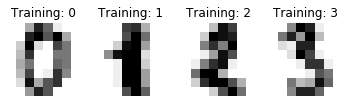

In [99]:
# Affichage des données 

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(original_images, original_target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = original_images.shape[0]
data = original_images.reshape((n_samples, -1))

#### Votre code

In [103]:
x_train, x_test, y_train, y_test = train_test_split(data, original_target)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1347, 64)
(1347,)
(450, 64)
(450,)


In [124]:
clf_rbf = svm.SVC(kernel='rbf', gamma=0.001)
clf_rbf.fit(x_train, y_train)
print(clf_rbf.score(x_test, y_test))

predictions = clf_rbf.predict(x_test)

print(predictions)

0.9933333333333333
[0 0 7 1 4 1 5 0 3 1 9 6 4 9 2 5 4 6 4 8 6 3 6 4 7 9 3 8 0 7 3 4 0 4 9 6 1
 1 2 2 6 5 6 4 9 7 0 7 2 1 2 8 7 9 1 0 7 5 2 7 6 8 9 5 1 2 4 0 1 0 1 9 0 1
 5 3 6 7 9 4 4 6 8 0 5 6 6 2 7 3 8 9 7 5 4 7 4 0 4 8 9 8 0 3 6 7 2 6 7 9 4
 3 1 9 1 9 6 9 6 3 4 9 4 2 2 2 2 8 1 4 7 8 3 7 3 8 7 8 3 0 7 9 3 1 0 8 6 3
 8 0 5 0 9 4 1 3 9 2 2 1 2 7 7 5 8 7 2 5 5 5 6 9 9 4 1 8 3 7 6 2 6 0 0 5 3
 7 4 1 6 3 8 8 3 4 6 4 2 6 2 4 1 4 2 9 6 8 0 0 9 8 6 6 1 7 7 8 9 0 6 1 6 3
 9 9 6 7 0 6 0 1 7 3 3 0 7 4 4 5 8 1 2 1 7 9 7 9 9 2 9 4 2 6 1 0 2 5 1 2 6
 4 6 9 5 2 5 8 8 9 3 6 2 4 1 9 4 4 2 7 9 7 9 3 1 7 9 6 3 5 5 8 0 2 3 6 2 5
 0 9 9 4 2 5 6 4 5 4 9 8 3 0 9 3 4 5 2 5 4 4 3 7 9 4 4 7 1 0 0 8 7 0 0 1 6
 5 4 1 4 6 9 1 3 4 5 2 5 0 5 3 8 5 7 7 7 4 0 9 1 8 4 9 2 6 1 5 0 9 6 2 4 7
 1 7 0 5 3 5 2 5 8 3 8 2 2 4 6 8 6 6 5 4 7 6 0 3 3 2 3 3 0 3 5 9 8 9 7 7 0
 1 6 9 8 8 3 4 8 3 4 5 0 2 2 7 2 7 2 3 1 2 3 7 5 2 5 6 0 9 0 7 7 5 3 6 4 9
 6 7 5 4 2 5]


* 3. générer des centaines d'images bruitées à partir d'une bonne prédiction de notre SVM

    * on veut (200, 64) à partir de (64,), donc on doit faire (200,64)@(64,64)

In [137]:
def generate_noisy_images_around_a_correct_prediction(n_samples, variance):
    for x in range(len(predictions)):
        # found one correct prediction
        if predictions[x] == y_test[x]:
            noise = np.random.normal(0, variance, (n_samples, x_test[x].shape[0]))

            # reproduce image and add some noise
            fake_images = np.matlib.repmat(x_test[x], n_samples, 1)
            fake_images += noise

            return fake_images, x_test[x], y_test[x]
            
n_samples = 500
variance = 5 # ultra important !!!
fake_images, real_image, real_target = generate_noisy_images_around_a_correct_prediction(n_samples, variance)

print(f'generated {n_samples} images with variance {variance}')
print(f'target real is {real_target}')
print(fake_images[0].shape)
print(real_image.shape)
print(fake_images.shape)

generated 500 images with variance 5
target real is 0
(64,)
(64,)
(500, 64)


* 4. prédire sur les images générées et apprendre un classifieur linéaire sur ce dataset

(1347, 64)
(500, 64)
[1 1 0 1 5 1 1 9 1 1 8 0 1 9 5 0 1 0 1 9 1 1 0 1 1 1 1 1 1 5 5 1 0 1 0 1 0
 1 9 1 0 0 1 0 0 0 8 2 0 1 1 5 1 0 0 1 0 1 9 1 1 1 9 1 0 1 8 1 1 0 1 1 0 8
 0 1 1 1 1 1 1 9 1 9 9 1 1 1 9 0 1 1 1 1 1 9 1 1 5 1 0 1 1 1 1 1 0 1 0 0 1
 1 1 1 9 0 1 1 1 1 1 1 1 0 1 1 8 5 1 9 9 1 1 0 1 0 1 9 1 9 0 0 1 9 0 2 1 9
 2 0 1 0 1 1 1 8 1 9 1 1 1 9 1 0 1 5 1 1 1 1 9 1 1 9 1 0 1 1 0 1 1 1 0 0 1
 0 1 1 1 1 1 2 1 0 1 1 1 1 1 0 8 1 1 0 1 1 0 1 1 0 0 9 0 9 1 9 9 8 1 2 1 1
 1 1 1 1 8 1 5 1 9 1 1 1 9 8 0 1 0 0 1 9 1 5 1 1 1 1 0 1 9 1 0 1 1 0 1 0 1
 1 1 1 0 9 1 5 9 1 1 1 1 1 9 1 0 0 0 1 9 0 1 1 1 8 1 1 2 0 1 1 1 9 8 1 1 1
 1 1 1 1 0 1 9 1 1 1 1 9 1 1 1 8 0 1 1 0 5 1 0 0 8 9 0 1 5 1 1 1 1 1 1 1 1
 9 1 4 1 1 1 1 1 1 0 9 5 1 1 9 1 5 1 0 1 1 1 8 1 9 1 1 0 1 1 1 1 5 1 0 1 0
 1 1 0 1 0 9 0 1 9 1 9 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 9 2 1 1 0 0 1 9 0 0
 1 1 1 1 0 9 1 1 8 1 1 1 1 0 1 3 1 1 1 1 1 8 1 1 1 1 1 9 0 8 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 1 8 1 1 0 9 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 5 1 1 1 1 1 0
 9 0

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


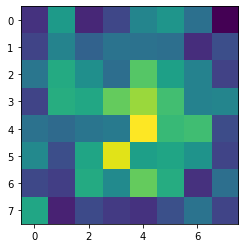

In [142]:
# yB
print(x_train.shape)
print(fake_images.shape)
fake_predictions = clf_rbf.predict(fake_images)
print(fake_predictions)

clf_linear = svm.LinearSVC()
clf_linear.fit(fake_images, fake_predictions)

# valeurs absolues des coefficients pour éviter qu'un poids à -1 d'un modèle
# `compense` un poids à 1 dans un autre modèle, ce qui reviendrait à dire que 
# la variable n'est pas explicative alors qu'elle l'est !
abs_coefficients = np.abs(clf_linear.coef_)

# on fait la moyenne des 3 modèles appris par le SVM
coefficients = abs_coefficients.sum(axis=0) / abs_coefficients.shape[0]

feature_names = ['pixel ' + str(x) for x in range(64)]

plt.imshow(coefficients.reshape(8, 8))
plt.show()

## Partie 2 : Surapprentissage sur les données Mnist 

Le code de la cellule suivante vous permet de récupérer les données Mnist.

In [144]:
# The digits dataset
digits = datasets.load_digits()
#print(digits.keys())

# convenient
original_data = digits.data
original_target = digits.target
original_target_names = digits.target_names
original_images = digits.images

print(f'original data shape {original_data.shape}')
print(f'original target shape {original_target.shape}')
print(f'original target names {original_target_names}')
print(f'original images shape {original_images.shape}')

# split train_test
x_train, x_test, y_train, y_test = train_test_split(original_data, original_target)

original data shape (1797, 64)
original target shape (1797,)
original target names [0 1 2 3 4 5 6 7 8 9]
original images shape (1797, 8, 8)


### Question 1. Mise en évidence du surapprentissage

Les modèles appris par apprentissage peuvent souffrir de surapprentissage, c'est à dire que leur comportement sur les données de généralisation est dégradé par rapport à ce qu'il pourrait être, alors que le comportement (la performance) sur les données d'apprentissage est très bon (par rapport à ce qu'il pourrait être pour de meilleures performances en généralisation). 

Construisez une expérience mettant en évidence ce phénomène avec les données MNIST. Il s'agit ici de faire varier le contexte expérimental de l'apprentissage pour faire apparaitre le phénomène. Vous pouvez utiliser tout ce vous voulez pour cela, utiliser tout ou partie des données d'apprentissage, idem pour les données de test, utiliser n'importe quel classifieur de la librairie sklearn etc.  


#### Votre réponse

* arbre de décision profond

#### Votre code

In [0]:
degree = 23

# transform into polynomial shape
poly = PolynomialFeatures(degree)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

In [0]:
# fit regressor
reg = linear_model.LinearRegression()
reg.fit(x_train_poly, y_train)

# scores
print(f'polynomial regression degree train {degree} -- {reg.score(x_train_poly, y_train)}')
print(f'polynomial regression degree test {degree} -- {reg.score(x_test_poly, y_test)}')

### Question 2. Réduire le surapprentissage

Diverses stratégies existent pour réduire le surapprentissage. Citez les principales et mettez une de ces stratégies en oeuvre pour le cas de surapprentissage identifié dans l'expérience que vous avez menée ci dessus.  

#### Votre réponse

* régularisation

* réduction du nombre de paramètres

* changer de famille de classifier

* SVM --> régularisation par augmentation de la constante C qui est le rapport entre la bonne classification et les poids du classifier (stratégies différentes)

#### Votre code

## Partie 3 

On s'intéresse ici à la régression linéaire multivariée. L'objectif est d'implémenter et comparer les perfermances de deux méthodes de régression, à savoir la régression par moindres carrés et la régression de faible rang.


### Question 1 : 

Expliquez le principe de la régression linéaire par moindres carrés (OLS). Dans le cas de sorties multiples (régression multivariée), donnez un avantage et un inconvénient de la régression par moindre carrés.



*Répondre ici*

* Minimisation du critère de l'erreur quadratique faite sur chacune des données d'apprentissage

* Avantages : facile d'implémenter, on peut résoudre de façon analytique.

* Inconvénients : sensible aux points abbérants. Si on apprend une régression de 100 par 100, on a 10_000 paramètres, pas optimal puisqu'on ne prend pas en compte les dépendances entre les sorties (revient à appliquer une reg linéaire sur chacune des sorties).


### Question 2 : 

Expliquez le principe de la régression linéaire de faible rang (LR). Dans le cas de sorties multiples (régression multivariée), donnez un avantage et un inconvénient de la régression de faible rang.



*Répondre ici*

* Dans le cas de sorties multiples, la reg de faible rang consiste à trouver une relation linéaire entre les données et de sortie qui minimise l'erreur quadratique (idem que OLS) avec une contrainte de rang sur les paramètres du modèle.

* Avantages : permet de tenir compte les dépendances entre les sorties.

* Inconvénients : très dépendant du paramètre *r* de la LR.

### Question 3 :

Ecrivez les fonctions d'apprentissage et de prédiction de la régression par moindres carrés.



*Répondre ici*

### Question 4 :

Ecrivez les fonctions d'apprentissage et de prédiction de la régression de rang faible.



*Répondre ici*

### Question 5 :

Réalisez des simulations permettant de comparer les deux méthodes de régression linéaire par moindres carrés et de rang faible. Les simulations doivent illustrer des situations où il est bénifique d'utiliser la régression de rang faible à la place de la régression par moindres carrés.  Comparez les performances  de reconstruction des vrais paramètres du modèle et prédictives des deux méthodes.



x shape (1000, 17)
y shape (1000, 11)
w shape (17, 11)


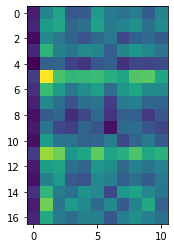

In [1]:
# Répondre ici - code
import numpy as np
import matplotlib.pyplot as plt

def generate_low_rank_matrix(n_samples,
                             n_features_input,
                             n_features_output,
                             rank):
    # noise
    epsilon = np.random.normal(0, 0.1, (n_samples, 1))

    # random data
    data = np.random.rand(n_samples, n_features_input)

    # weights matrix constructed by 2 transitional matrices
    alpha = np.random.rand(n_features_input, rank)
    beta = np.random.rand(rank, n_features_output)
    weights = alpha @ beta

    # construct noisy targets
    target = data @ weights + epsilon

    return data, target, weights

n_samples, n_features_input, n_features_output, rank = 1000, 17, 11, 3
x, y, w = generate_low_rank_matrix(n_samples, n_features_input, n_features_output, rank)

print(f'x shape {x.shape}')
print(f'y shape {y.shape}')
print(f'w shape {w.shape}')

# plot the low ranked matrix
plt.imshow(w)
plt.show()

*Répondre ici*

### Question 6 :

Générez un jeu de données de régression nonlinéaire. Appliquez et comparez les performances de la régression  par moindres carrés et de faible rang sur ce jeu de données. Que contsatez-vous ? Proposez une solution pour améliorer les performances de prédiction de ces ceux méthodes. 

In [0]:
# Répondre ici - code

*Répondre ici*